## Twitter Sentiment Analysis

Dataset Source: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

##### Import Necessary Libraries

In [0]:
import pandas

import pyspark

import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

from sklearn.metrics import classification_report

#### Define Functions Used Throughout This Project

##### Create Function to Ingest Data (& Do Some Preprocessing)

In [0]:
def ingest_data(file_location: str, schema: StructType) -> pandas.DataFrame:
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "false"
    delimiter = ","
    
    dataset = spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .schema(schema)\
        .load(file_location)
    
    dataset = dataset.drop("tweet_id").drop("entity")

    dataset = dataset.dropDuplicates()

    dataset = dataset.na.drop()
    
    dataset = dataset.filter(dataset.label.isin(["Positive", "Neutral", "Negative"])) # Pipeline used only categorizes positive, neutral, & negative tweets
    
    return dataset

##### Function to Remove Imbalance in Classes (Outputs)

In [0]:
def balance_dataset(dataset: pandas.DataFrame, unique_label_values: [], samples: int = 20000, label_col: str = "label") -> pandas.DataFrame:
    temp_df =  spark.createDataFrame([], new_schema)
    new_df =  spark.createDataFrame([], new_schema)
    
    for ulab in unique_label_values:
        # extract df of only the desired labels
        temp_df = dataset.where(F.col(label_col).isin(ulab))
        # sample it to desired number of samples
        temp_df = temp_df.sample(False, round(samples/temp_df.count(),4), seed=42)
        # concatenate it to the new_df
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    return new_df

##### Define Function to Evaluate Model & Display Metrics

In [0]:
def metrics_eval(prediction: pandas.Series, label: pandas.Series, model_name: str) -> None:
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    
    print("-------------------------------------------------------------")
    print(f"The {model_name} Model:")
    print("-------------------------------------------------------------")
    print(f"Classification Report for the {model_name} Model:")
    
    report = classification_report(label, prediction, zero_division=1)
    print(report)
    
    print("-------------------------------------------------------------")
    
    print(f"Confusion Matrix for the {model_name} Model:")
    cm = confusion_matrix(label, prediction)
    dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()
    
    print("-------------------------------------------------------------")

#### Ingest & Preprocess Data

##### Ingest Dataset

In [0]:
# File location and type
file_1 = "/FileStore/tables/twitter_training.csv"
file_2 = "/FileStore/tables/twitter_validation.csv"

orig_schema = StructType([
         StructField('tweet_id', IntegerType(), True),
         StructField('entity', StringType(), True),
         StructField('label', StringType(), True),
         StructField('text', StringType(), True)
         ])

input_files = [file_1, file_2]

df = ingest_data(input_files, orig_schema)

display(df)

label,text
Positive,Just uninstalled all of my other games to make space for Borderlands 3 .
Neutral,"Messed up downloading the new borderlands 3 dlc yet again. Assume the update is the patch and dlc, but like the previous one even with the season pass this has to be immediately added from ps store and downloaded"
Positive,Actually. I rather think 13 borderlands 3 might be my 5th fave. 3 But then it certainly wouldn't be stand alone.... But still god do I really love and enjoy bl3!!!
Neutral,bURn aALL tHe BiES.
Positive,"Finally played through borderlands 5. The actual game play is great. Almost all guns were fun, and I never once felt sure I needed to grind. That story is the other hand.... but I will say now oh yes'm very much so looking forward to the extended cutscene skip :)"
Positive,Bioshock AND borderlands coming after your switch bitch count me the fuck in
Negative,@EpicGames @2K @Steam why add crossplay for @Borderlands 3 if you weren't gonna make it compatible for console? What a waste
Neutral,"Hold your chin up, SO I CAN DREAM IT WITH A HAMMER!!. Chaotic reviews for the latest Borderlands 3 DLC:.. Psycho War and the Fantastic Fustercluck... youtu.be / vCBRxRL46UY"
Neutral,"Keep your chin held up, or SO GO I CAN SMASH IT AND WITH A HAMMER!!.. Chaotic Digital reviews the upcoming newest Borderlands Part 3 game DLC :.. Psycho to Krieg Ghost and the Fantastic Fustercluck.. youtu. be / vCBRxRL46UY"
Positive,.


Output can only be rendered in Databricks

##### Remove Data Imbalance & Return 17,000 Samples From Both Classes/Outputs

In [0]:
new_schema = StructType([
         StructField('label', StringType(), True),
         StructField('text', StringType(), True)
         ])

uniq_label_vals = ["Negative", "Neutral", "Positive"]

ds = balance_dataset(df, uniq_label_vals, 17000)
print(f"There are {ds.count()} samples currently in this dataset")

# Convert 'label' values to all lowercase to match the labels in the pretrained model
ds = ds.withColumn("label", F.lower(F.col("label")).alias("label"))

display(ds)

There are 51075 samples currently in this dataset


label,text
negative,Thats kinda a scary move..
negative,"No, no"
negative,Immediately my pc is crying
negative,"I’m really bad on amazon today! I ordered a kindle from lightning deal, but later the order was cancelled due to hardware issue! When i try to request email again, it says the delivery is already claimed, which am so disappointing! @amazonIN @AmazonHelp"
negative,"Hey @amazon I understand with everything going on there's a delay in actually shipping orders but why is it when they are now shipped (which has been relatively quick) , they are going out 7 day ups ground? Where's the 2 day shipping prime members paid for?"
negative,"@amazon your turkey organisation is a mess, BIG MESS!"
negative,I’m just gonna say it - Overwatch essentially being nominated for LGBTQ+ game of the year is worse than if Rise of Skywalker was nominated for LGBTQ+ film of the year. At least in Rise of Skywalker if you slow the footage down and zoom in you can see gay shit if you squint.
negative,"Already lost it, games shit"
negative,yooo the first serves just went down to
negative,"I didn't like the idea originally, but I'd MUCH rather have hero bans for each match that players control over some randomized randomized pool of bans. Online pools will just cause more problems for Overwatch than anything else."


Output can only be rendered in Databricks

#### Build Pipeline Stages & Instantiate Pipeline

##### Build Pipeline Stages

In [0]:
MODEL_NAME='sentimentdl_use_twitter'

document_assembler = DocumentAssembler() \
    .setInputCol("text")\
    .setOutputCol("doc")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["doc"])\
    .setOutputCol("use")

sent_dl_clf = SentimentDLModel.pretrained(MODEL_NAME, lang='en')\
    .setInputCols(["use"])\
    .setOutputCol("class")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


##### Build Pipeline

In [0]:
sent_dl_pipe = Pipeline().setStages([document_assembler, use, sent_dl_clf])

#### Inference & Model Evaluation

##### Inference: Predictions Using Test Dataset & Return Only Clean & Necessary Features

In [0]:
preds = sent_dl_pipe.fit(ds).transform(ds)

preds_in_pandas = (preds.select(F.col('text').alias("text"), F.col('label').alias("ground_truth"), F.col('class.result').alias("prediction"))).toPandas()

preds_in_pandas['prediction'] = preds_in_pandas['prediction'].apply(lambda x : x[0])

display(preds_in_pandas)

text,ground_truth,prediction
Thats kinda a scary move..,negative,negative
"No, no",negative,negative
Immediately my pc is crying,negative,negative
"I’m really bad on amazon today! I ordered a kindle from lightning deal, but later the order was cancelled due to hardware issue! When i try to request email again, it says the delivery is already claimed, which am so disappointing! @amazonIN @AmazonHelp",negative,negative
"Hey @amazon I understand with everything going on there's a delay in actually shipping orders but why is it when they are now shipped (which has been relatively quick) , they are going out 7 day ups ground? Where's the 2 day shipping prime members paid for?",negative,negative
"@amazon your turkey organisation is a mess, BIG MESS!",negative,negative
I’m just gonna say it - Overwatch essentially being nominated for LGBTQ+ game of the year is worse than if Rise of Skywalker was nominated for LGBTQ+ film of the year. At least in Rise of Skywalker if you slow the footage down and zoom in you can see gay shit if you squint.,negative,negative
"Already lost it, games shit",negative,negative
yooo the first serves just went down to,negative,positive
"I didn't like the idea originally, but I'd MUCH rather have hero bans for each match that players control over some randomized randomized pool of bans. Online pools will just cause more problems for Overwatch than anything else.",negative,negative


##### Calculate & Display Metrics

-------------------------------------------------------------
The Sentiment Analysis Model:
-------------------------------------------------------------
Classification Report for the Sentiment Analysis Model:
              precision    recall  f1-score   support

    negative       0.53      0.75      0.62     17108
     neutral       0.35      0.04      0.07     16998
    positive       0.48      0.71      0.57     16969

    accuracy                           0.50     51075
   macro avg       0.45      0.50      0.42     51075
weighted avg       0.45      0.50      0.42     51075

-------------------------------------------------------------
Confusion Matrix for the Sentiment Analysis Model:
-------------------------------------------------------------


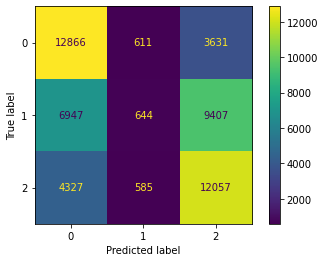

In [0]:
metrics_eval(preds_in_pandas['prediction'], preds_in_pandas['ground_truth'], "Sentiment Analysis")

##### End Spark Session

In [0]:
spark.stop()

### Notes & Other Takeaways From This Project
****
- I am disappointed that the results were not better. Even though I had to remove the 'Irrelevant' class from the dataset, I would have thought that a pretrained model for sentiment analysis using tweets would have yielded better results. I guess this model is rather 'irrelevant'!
****
- I am tempted to run this project via the HuggingFace Trainer API to see what the result is.
****